# In the following notebook we will make an overview of the venues found in the 4 big cities of the region of Thessaly in Greece : 
# Volos, Larisa, Trikala, Karditsa

Foursquare is a platform whose purpose is to help people discover and share information about businesses and attractions around them. <br>
We will use it to acquire info for any venues in the cities above

#### Let's find the cities geographical coordinates and show them in a map

In [1]:
from geopy.geocoders import Nominatim

In [2]:
geolocator = Nominatim(user_agent="my_explorer")

In [3]:
def find_coordinates(city_name, city_country):
    global geolocator
    city = city_name + "," + city_country
    
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    
    return (latitude,longitude,city_name)

In [4]:
volos = find_coordinates("Volos" , "Greece")
larisa = find_coordinates("Larisa", "Greece")
karditsa = find_coordinates("Karditsa", "Greece")
trikala = find_coordinates("Trikala", "Greece")

In [5]:
import folium

In [6]:
greek_map = folium.Map(location=(39.37762123,22.38574209), zoom_start=7)
folium.Marker((volos[0],volos[1]), popup = (volos[2])).add_to(greek_map)
folium.Marker((larisa[0],larisa[1]), popup = (larisa[2])).add_to(greek_map)
folium.Marker((karditsa[0],karditsa[1]), popup = (karditsa[2])).add_to(greek_map)
folium.Marker((trikala[0],trikala[1]), popup = (trikala[2])).add_to(greek_map)

greek_map

Since we had to make over 50 Premium Calls to the Foursqauare API endpoint, we had to upgrade the default Sandbox Account to Personal Non-Commercial verified Account

# 1. create the functions we will use for our interaction with Foursquare

#### first we pass credentials for the 4square API

In [100]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20210331' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
PREMIUM_CALLS = 0

print('Your credentails:')
print('CLIENT_ID      :  ' + CLIENT_ID)
print('CLIENT_SECRET  :  ' + CLIENT_SECRET)
print('ACCESS_TOKEN   :  ' + ACCESS_TOKEN)

Your credentails:
CLIENT_ID      :  
CLIENT_SECRET  :  
ACCESS_TOKEN   :  


In [8]:
base_4square_url = "https://api.foursquare.com/v2/venues/"

In [9]:
import requests
import pandas as pd
import numpy as np

#### function to split the categories of a venue

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### function to get the ratings of a dataframe of venues, creates a new column ['rating']

The ratings of 4square venues are in the range from 0 to 10 being the highest

In [11]:
'''
input is a dataframe containing a column ['id']
for every venue with id in column ['id'] an HTTP Request is made to the Fousquare API to get the rating for the venue

output is the same dataframe appended with a column columns ['rating'] with the rating for every venue
if no rating is found for a venue it is assigned np Nan
'''

def get_venues_rating(dataframe_to_rate):
    global PREMIUM_CALLS
    
    all_ratings = []
    for curr_id in dataframe_to_rate['id']:
        url = base_4square_url + '{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(
            curr_id,
            CLIENT_ID,
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION)
        result = requests.get(url).json()
        print(result)
        PREMIUM_CALLS = PREMIUM_CALLS + 1
        try:
            rating = result['response']['venue']['rating']
        except:
            rating = np.nan
        finally:
            all_ratings.append(rating)
    
    dataframe_to_rate['rating'] = all_ratings
    return dataframe_to_rate

#### function to explore venues around a given in (lat,lng) location,  returns dataframe of  [ 'name' ,'id', 'lat' , 'lng', 'categories']

In [12]:
'''
input city is the tuple of the city we search trends for (latitude, longitude, name)
the radius to search around the city's coordinates is set by default at 6km if not given otherwise

output is a datafrme with columns ['name', 'categories', 'rating', 'latitude','longitude', 'id']
and row the trends found
if no venues are found  returns None
'''

def get_explore(city, radius = 3000):
    latitide = city[0]
    longitude = city[1]
    city_name = city[2]
    
    page = 0
    # create an empty dataframe
    df_returned = pd.DataFrame(columns = ["name", "categories", "rating" , "latitude" ,"longitude","id",])
    
    # as long as venues come by x100 and it is not the first hit of 4square
    while ( ( len(df_returned) % 100 == 0 ) or (page == 0)):
    
         # create the API request URL
        url = base_4square_url + 'explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                latitide, 
                longitude, 
                radius, 
                LIMIT,
                page)
        print( requests.get(url).json())
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

         # tranform venues into a dataframe
        explored_df = pd.json_normalize(results)
        if explored_df.empty:
            if (page == 0):
                print("No venues were found exploring for " + city_name)
                return df_returned
            else :
                print("no of hits" + str(page + 1) + "for " + city_name)
                return df_returned

        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat','venue.location.lng', 'venue.id'] 
        explored_df = explored_df.loc[:, filtered_columns]
        explored_df.rename(columns={
                'venue.name' : 'name','venue.categories' :'categories','venue.location.lat': 'latitude', 
                'venue.location.lng': 'longitude', 'venue.id' : 'id'}, inplace=True)
        # filter the category for each row
        explored_df['categories'] = explored_df.apply(get_category_type, axis=1)
        explored_df['rating'] = get_venues_rating(explored_df)
        
        # append the dataframe of each GET Requesrt to the total and  update offset parameter for new HTTP Request
        df_returned = pd.concat([df_returned,explored_df])
        page = page + 1
    
    return(df_returned)

#### function to find trends around a given in (lat,lng) location,  returns dataframe of  [ 'name' ,'id', 'lat' , 'lng', 'categories']

The radius when searching is set by default at 3 km, so as to fit the whole cities. For the city of Volos specifically, the radius will be at 7 km . That is because the city is located right next to the mountain Pilion and to the sea. As a lot of it's economy relies on the tourism, local and foreign, but to mountain activities too, while the locals live in the city.

In [13]:
'''
input city is the tuple of the city we search trends for (latitude, longitude, name)
the radius to search around the city's coordinates is set by default at 6km if not given otherwise

output is a datafrme with columns ['name', 'categories', 'location.lat','location.lng', 'id']
and row the trends found
if no trends are found a message is printed "No trends were forund for cityname" and returns None
'''

def get_trends(city, radius = 6000 ):
    latitude = city[0]
    longitude = city[1]
    city_name = city[2]
    
    url = base_4square_url + 'trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        latitude,
        longitude,
        VERSION)

    results = requests.get(url).json()
    items = results['response']['venues']
        
    if (len(items) == 0) :
        print("No trends were forund for " + city_name)
        return None
    else :
        # tranform venues into a dataframe
        trends_df = pd.json_normalize(items)
            
        filtered_columns = ['name', 'categories', 'location.lat','location.lng', 'id'] 
        trends_df = trends_df.loc[:, filtered_columns]
        trends_df.rename(columns={
            'venue.name' : 'name','venue.categories' :'categories','venue.location.lat': 'latitude', 
            'venue.location.lng': 'longitude', 'venue.id' : 'id'}, inplace=True)
        # filter the category for each row
        trends_df['categories'] = trends_df.apply(get_category_type, axis=1)
            
        # append the dataframe of each GET Requesrt to the total and  update offset parameter for new HTTP Request
        df_returned = pd.concat([df_returned,trends_df])
        
    return df_returned

# 2. collect the data for the analysis

### See if there are any trends for the 4 cities

In [14]:
karditsa_trends = get_trends(city = karditsa)

No trends were forund for Karditsa


In [15]:
volos_trends = get_trends(city = volos)

No trends were forund for Volos


In [16]:
larisa_trends = get_trends(city = larisa)

No trends were forund for Larisa


In [17]:
trikala_trends = get_trends(city = trikala)

No trends were forund for Trikala


We did not get any trends, but this is expected since the country of Greece is in lockdown due to covid19 pandemic.
We will only take into account the venues that have already been defined from the previous years.

### Expore the 4 cities

for Volos

In [18]:
# volos_venues = get_explore(city = volos, radius = 6000)
# volos_venues = get_venues_rating(volos_venues)
# volos_venues.to_csv("volos____csv", encoding='utf-8', index=False)
# print("Total venues found for Volos : " + str(len(volos_venues)))
# volos_venues.head()

# I run the upper lines to create a csv for the venues of Athens
# for faster computations, and also to keep it for furher analysis if it is ever needed
volos_venues = pd.read_csv("volos____csv")
print("Total venues found for Volos : " + str(len(volos_venues)))
volos_venues.head(3)

Total venues found for Volos : 63


,name,categories,rating,latitude,longitude,id
0,Στάφυλος,Greek Restaurant,9.1,39.362710,22.936797,508ee4afe4b0d3ece72db97a
1,Αββαείο,Beer Bar,8.6,39.364999,22.932674,4e20bdaa62e1964dbb5fe704
2,Μουσειον Εκλεκτοποιειον,Meze Restaurant,8.4,39.364219,22.935708,55d8d164498e8a31518a0572


for Larisa

In [19]:
# larisa_venues = get_explore(city = larisa)
# larisa_venues = get_venues_rating(larisa_venues)
# larisa_venues.to_csv("larisa____csv", encoding='utf-8', index=False)
# print("Total venues found for Larisa : " + str(len(larisa_venues)))
# larisa_venues.head(15)

# I run the upper lines to create a csv for the venues of Athens
# for faster computations, and also to keep it for furher analysis if it is ever needed
larisa_venues = pd.read_csv("larisa____csv")
print("Total venues found for Larisa : " + str(len(larisa_venues)))
larisa_venues.head(3)

Total venues found for Larisa : 78


,name,categories,rating,latitude,longitude,id
0,Ancient Theatre of Larissa (Αρχαίο Θέατρο Λάρι...,Historic Site,9.2,39.640008,22.414713,4c40a11fda3dc928fea3c7b9
1,Henry Charles Bukowski,Gastropub,8.7,39.639321,22.416635,51ed2d50498e68bb8e0e4172
2,Kubrick Pure Social Club,Cocktail Bar,8.8,39.636611,22.418841,4c0af607ffb8c9b642936c61


for Karditsa

In [20]:
# karditsa_venues = get_explore(city = karditsa)
# karditsa_venues = get_venues_rating(karditsa_venues)
# karditsa_venues.to_csv("karditsa____csv", encoding='utf-8', index=False)
# print("Total venues found for Karditsa : " + str(len(karditsa_venues)))
# karditsa_venues.head(15)

# I run the upper lines to create a csv for the venues of Karditsa
# for faster computations, and also to keep it for furher analysis if it is ever needed
karditsa_venues = pd.read_csv("karditsa____csv")
print("Total venues found for Karditsa : " + str(len(karditsa_venues)))
karditsa_venues.head(3)

Total venues found for Karditsa : 52


,name,categories,rating,latitude,longitude,id
0,a mano espresso bar,Coffee Shop,8.8,39.364416,21.922878,4ff67c01e4b0b3e698ad5947
1,Ciao Espresso Bar,Café,8.2,39.363817,21.921007,4e0ad456b61cf2466a0aa0f6
2,τόσο δα,Café,8.4,39.364514,21.925761,4f85db97e4b0657ba80b0f68


for Trikala

In [21]:
# trikala_venues = get_explore(city = trikala)
# trikala_venues = get_venues_rating(trikala_venues)
# trikala_venues.to_csv("trikala____csv", encoding='utf-8', index=False)
# print("Total venues found for Trikala : " + str(len(trikala_venues)))
# trikala_venues.head(15)

# I run the upper lines to create a csv for the venues of Athens
# for faster computations, and also to keep it for furher analysis if it is ever needed
trikala_venues = pd.read_csv("trikala____csv")
print("Total venues found for Trikala : " + str(len(trikala_venues)))
trikala_venues.head(3)

Total venues found for Trikala : 79


,name,categories,rating,latitude,longitude,id
0,The Love Shake,Bar,8.4,39.556820,21.767342,551ce43c498e4f92ab333677
1,Telemachos Cinema,Movie Theater,8.9,39.560597,21.768655,4c0c0422ffb8c9b6de246e61
2,Κεντρική Πλατεία Τρικάλων,Plaza,8.3,39.556058,21.767864,4de53d1052b16c61fe302205


<br>

In [22]:
print("Total venues obtained from Foursquare : " + str(len(volos_venues) + len(larisa_venues) + len(trikala_venues) +len(karditsa_venues)))

Total venues obtained from Foursquare : 272


As the number of total venues per city is similar, so is the number of different venue categories

<br>

In [23]:
print("Volos    - " + "  total venues : " + str(len(volos_venues)) + "  different venue cateogries : " + str(len(volos_venues['categories'].unique())))
print("Larisa   - " + "  total venues : " + str(len(larisa_venues)) + "  different venue cateogries : " + str(len(larisa_venues['categories'].unique())))
print("Trikala  - " + "  total venues : " + str(len(trikala_venues)) + "  different venue cateogries : " + str(len(trikala_venues['categories'].unique())))
print("Karditsa - " + "  total venues : " + str(len(karditsa_venues)) + "  different venue cateogries : " + str(len(karditsa_venues['categories'].unique())))

Volos    -   total venues : 63  different venue cateogries : 34
Larisa   -   total venues : 78  different venue cateogries : 38
Trikala  -   total venues : 79  different venue cateogries : 39
Karditsa -   total venues : 52  different venue cateogries : 26


## 3. Data cleaning

In [24]:
pd.set_option('display.max_rows', 93)

#### Take all unique venue categories 

In [25]:
unique_categories = np.concatenate((volos_venues['categories'].unique(), larisa_venues['categories'].unique() ,karditsa_venues['categories'].unique(), trikala_venues['categories'].unique()), axis=0)

unique_categories = np.sort(np.unique(unique_categories))
print("Total venue categories :  "+ str(len(unique_categories)))
print(unique_categories)

Total venue categories :  78
['Airport' 'Art Museum' 'Athletics & Sports' 'Auto Dealership'
 'Automotive Shop' 'BBQ Joint' 'Bakery' 'Bar' 'Basketball Court' 'Beach'
 'Beach Bar' 'Beer Bar' 'Beer Garden' 'Beer Store' 'Bistro' 'Bus Station'
 'Cafeteria' 'Café' 'Clothing Store' 'Cocktail Bar' 'Coffee Shop'
 'Creperie' 'Dance Studio' 'Dessert Shop' 'Electronics Store'
 'Fast Food Restaurant' 'Flower Shop' 'Fried Chicken Joint' 'Gas Station'
 'Gastropub' 'Gift Shop' 'Greek Restaurant' 'Grilled Meat Restaurant'
 'Gym' 'Gym / Fitness Center' 'Historic Site' 'History Museum' 'Hotel'
 'Hotel Bar' 'Ice Cream Shop' 'Italian Restaurant' 'Juice Bar' 'Kafenio'
 'Magirio' 'Meze Restaurant' 'Mobile Phone Shop'
 'Modern European Restaurant' 'Modern Greek Restaurant'
 'Monument / Landmark' 'Mountain' 'Movie Theater' 'Multiplex'
 'Music Venue' 'Nightclub' 'Outdoor Event Space' 'Ouzeri' 'Park'
 'Pedestrian Plaza' 'Pizza Place' 'Playground' 'Plaza' 'Resort'
 'Restaurant' 'Scenic Lookout' 'Seafood Restauran

from the venues of the dataframes above, we will erase some, since their category is of no interest to our research

In [26]:
erased_categories = sorted(['Warehouse Store','Train Station','Multiplex','Mobile Phone Shop','Gift Shop','Gas Station','Auto Dealership','Automotive Shop','Bus Station','Clothing Store','Electronics Store','Flower Shop'])
print("Total venue categories erased :  " + str(len(erased_categories)))

Total venue categories erased :  12


we will merge the different categories of venues to 7 bigger venue types

It might seem strange to an unkonown eye, but we will make a distinct category of caffes. In greek culture the coffe has an important role. As a result we will see a lot of caffetterias, and that is something to be expected.

In [27]:
alcohol = sorted(['Wine Bar','Bar','Beach Bar', 'Beer Bar' ,'Beer Garden', 'Beer Store', 'Bistro','Cocktail Bar','Gastropub','Hotel Bar'])
athletic = sorted(['Soccer Field', 'Soccer Stadium','Athletics & Sports','Basketball Court','Dance Studio','Gym', 'Gym / Fitness Center'])
caffes = sorted(['Cafeteria', 'Café', 'Coffee Shop','Kafenio'])
cultural = sorted(['Music Venue','Art Museum','Historic Site' ,'History Museum','Movie Theater','Shopping Mall'])
food = sorted(['Tsipouro Restaurant','Souvlaki Shop', 'Supermarket', 'Taverna','Snack Place','Seafood Restaurant','Restaurant','Pizza Place','Ouzeri','Modern European Restaurant', 'Modern Greek Restaurant','Magirio', 'Meze Restaurant','Italian Restaurant', 'Juice Bar','BBQ Joint', 'Bakery','Fast Food Restaurant','Fried Chicken Joint','Greek Restaurant', 'Grilled Meat Restaurant'])
leisure = sorted(['Theme Park', 'Toy / Game Store','Scenic Lookout','Playground' ,'Plaza' ,'Resort','Park','Pedestrian Plaza','Nightclub', 'Outdoor Event Space','Airport','Beach','Hotel','Monument / Landmark' ,'Mountain'])
sweets = sorted(['Creperie','Dessert Shop','Ice Cream Shop'])

venue_types = ["food", "caffes", "alcohol", "leisure", "athletic", "cultural", "sweets"]

In [28]:
# print( len(unique_categories) - len(erased_categories) - len(alcohol) - len(athletic) - len(caffes) - len(cultural) - len(food) - len(leisure)- len(sweets) )
# for cat in unique_categories:
#     if ((cat not in erased_categories) and (cat not in alcohol) and (cat not in athletic) and (cat not in caffes) and (cat not in cultural) and (cat not in food) and (cat not in leisure) and (cat not in sweets)):
#         print(cat)
# print()

print("venue categories to be erased, " + str(len(erased_categories))+ " in total")
print(erased_categories)
print()
print()
print("Venue categories for our anaysis")
print()
print("alcohol, with total venue categories :  " + str(len(alcohol)))
print(alcohol)
print()
print("athletic, with total venue categories :  " + str(len(athletic)))
print(athletic)
print()
print("caffes, with total venue categories :  " + str(len(caffes)))
print(caffes)
print()
print("cultural, with total venue categories :  " + str(len(cultural)))
print(cultural)
print()
print("food, with total venue categories :  " + str(len(food)))
print(food)
print()
print("leisure, with total venue categories :  " + str(len(leisure)))
print(leisure)
print()
print("sweets, with total venue categories :  " + str(len(sweets)))
print(sweets)
print()

venue categories to be erased, 12 in total
['Auto Dealership', 'Automotive Shop', 'Bus Station', 'Clothing Store', 'Electronics Store', 'Flower Shop', 'Gas Station', 'Gift Shop', 'Mobile Phone Shop', 'Multiplex', 'Train Station', 'Warehouse Store']


Venue categories for our anaysis

alcohol, with total venue categories :  10
['Bar', 'Beach Bar', 'Beer Bar', 'Beer Garden', 'Beer Store', 'Bistro', 'Cocktail Bar', 'Gastropub', 'Hotel Bar', 'Wine Bar']

athletic, with total venue categories :  7
['Athletics & Sports', 'Basketball Court', 'Dance Studio', 'Gym', 'Gym / Fitness Center', 'Soccer Field', 'Soccer Stadium']

caffes, with total venue categories :  4
['Cafeteria', 'Café', 'Coffee Shop', 'Kafenio']

cultural, with total venue categories :  6
['Art Museum', 'Historic Site', 'History Museum', 'Movie Theater', 'Music Venue', 'Shopping Mall']

food, with total venue categories :  21
['BBQ Joint', 'Bakery', 'Fast Food Restaurant', 'Fried Chicken Joint', 'Greek Restaurant', 'Grilled Meat

#### function to drop the venues that are of category that does not interest our analysis, and insert a new column['type'] for the 7 venue types we described above

In [29]:
'''
input city is a dataframe containing a column ['categories']
for every row, if the value in column ['categories'] is contained in the erased_categories from above, the row is erased
otherwise in the new column ['type'] that is created,
for every row it is assigned the appropriate value from venue_types from above

output is a dataframe with columns ['name', 'categories','type','rating','latitude','longitude','id']
'''

def filter_categories(dataframe_filterd, erased_categories):
    # drop the rows that the vanue's catory is in the erased_categories
    df_filterd = dataframe_filterd[~dataframe_filterd['categories'].isin(erased_categories)]
    
    conditions = [
    (df_filterd['categories'].isin(food)),
    (df_filterd['categories'].isin(leisure)),
    (df_filterd['categories'].isin(sweets)),
    (df_filterd['categories'].isin(alcohol)),
    (df_filterd['categories'].isin(cultural)),
    (df_filterd['categories'].isin(caffes)),
    (df_filterd['categories'].isin(athletic))
    ]
    choices = ['food', 'leisure', 'sweets','alcohol', 'cultural', 'caffes', 'athletic']
    df_filterd['type'] = np.select(conditions, choices)
    
    # insert the column ['type'] after the ['categories']
    df_filterd = df_filterd[['name', 'categories','type','rating','latitude','longitude','id']]
    df_filterd.reset_index(drop=True, inplace=True)
    return df_filterd

#### we filter the dataframes for every city

In [30]:
import warnings
from pandas.core.common import SettingWithCopyWarning

In [31]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [32]:
volos_venues = filter_categories(volos_venues , erased_categories)
print("Total venues for Volos :  "+ str(len(volos_venues)))
volos_venues.head()

Total venues for Volos :  60


,name,categories,type,rating,latitude,longitude,id
0,Στάφυλος,Greek Restaurant,food,9.1,39.362710,22.936797,508ee4afe4b0d3ece72db97a
1,Αββαείο,Beer Bar,alcohol,8.6,39.364999,22.932674,4e20bdaa62e1964dbb5fe704
2,Μουσειον Εκλεκτοποιειον,Meze Restaurant,food,8.4,39.364219,22.935708,55d8d164498e8a31518a0572
3,Brighton (Μπράιτον),Modern Greek Restaurant,food,8.6,39.362038,22.936012,58dbb915a6118c29f6591c3b
4,La Petite Cantine,Beer Garden,alcohol,8.6,39.361816,22.937172,57a0f331498ec1202d5ad6b4


Larisa

In [33]:
larisa_venues = filter_categories(larisa_venues , erased_categories)

print("Total venues for Larisa :  "+ str(len(larisa_venues)))
larisa_venues.head(3)

Total venues for Larisa :  73


,name,categories,type,rating,latitude,longitude,id
0,Ancient Theatre of Larissa (Αρχαίο Θέατρο Λάρι...,Historic Site,cultural,9.2,39.640008,22.414713,4c40a11fda3dc928fea3c7b9
1,Henry Charles Bukowski,Gastropub,alcohol,8.7,39.639321,22.416635,51ed2d50498e68bb8e0e4172
2,Kubrick Pure Social Club,Cocktail Bar,alcohol,8.8,39.636611,22.418841,4c0af607ffb8c9b642936c61


Trikala

In [34]:
trikala_venues = filter_categories(trikala_venues , erased_categories)

print("Total venues for Trikala :  "+ str(len(trikala_venues)))
trikala_venues.head()

Total venues for Trikala :  74


,name,categories,type,rating,latitude,longitude,id
0,The Love Shake,Bar,alcohol,8.4,39.556820,21.767342,551ce43c498e4f92ab333677
1,Telemachos Cinema,Movie Theater,cultural,8.9,39.560597,21.768655,4c0c0422ffb8c9b6de246e61
2,Κεντρική Πλατεία Τρικάλων,Plaza,leisure,8.3,39.556058,21.767864,4de53d1052b16c61fe302205
3,ρετούς,Cocktail Bar,alcohol,8.3,39.554751,21.766923,5526584c498e45cb82b2652a
4,Πράσινος Μύλος,Bakery,food,8.3,39.554588,21.767339,518a011b498eb03ced0ec419


Karditsa

In [35]:
karditsa_venues = filter_categories(karditsa_venues , erased_categories)

print("Total venues for Karditsa :  "+ str(len(karditsa_venues)))
karditsa_venues.head()

Total venues for Karditsa :  50


,name,categories,type,rating,latitude,longitude,id
0,a mano espresso bar,Coffee Shop,caffes,8.8,39.364416,21.922878,4ff67c01e4b0b3e698ad5947
1,Ciao Espresso Bar,Café,caffes,8.2,39.363817,21.921007,4e0ad456b61cf2466a0aa0f6
2,τόσο δα,Café,caffes,8.4,39.364514,21.925761,4f85db97e4b0657ba80b0f68
3,Παυσίλυπο,Park,leisure,8.8,39.364462,21.928102,4c93857a6b35a14390aa12dc
4,Fitness Forum,Gym / Fitness Center,athletic,8.4,39.361108,21.923853,4ce2973769136dcb9845f0e6


In [36]:
print("Total size of dataset after removing not needed venues : " + str(len(volos_venues) + len(larisa_venues) + len(trikala_venues) +len(karditsa_venues)))

Total size of dataset after removing not needed venues : 257


## 4. Data exploration

#### Display vanues per category for every city

In [37]:
volos_barplot_categories = volos_venues['type'].value_counts().sort_values().to_frame()
larisa_barplot_categories = larisa_venues['type'].value_counts().sort_values().to_frame()
trikala_barplot_categories = trikala_venues['type'].value_counts().sort_values().to_frame()
karditsa_barplot_categories = karditsa_venues['type'].value_counts().sort_values().to_frame()

cities_categories = volos_barplot_categories.rename(columns={'type' : 'volos'})
cities_categories = cities_categories.merge(larisa_barplot_categories.rename(columns={'type' : 'larisa'}), left_index=True, right_index=True)
cities_categories = cities_categories.merge(trikala_barplot_categories.rename(columns={'type' : 'trikala'}), left_index=True, right_index=True)
cities_categories = cities_categories.merge(karditsa_barplot_categories.rename(columns={'type' : 'karditsa'}), left_index=True, right_index=True)

cities_categories = cities_categories.reindex(index=venue_types, columns=sorted(cities_categories.columns))

cities_categories

,karditsa,larisa,trikala,volos
food,15,20,22,23
caffes,11,18,15,8
alcohol,9,10,10,14
leisure,6,10,15,12
athletic,2,7,4,1
cultural,2,5,3,1
sweets,5,3,5,1


see them visually in horizontal barplots

In [38]:
import matplotlib.pyplot as plt
import math

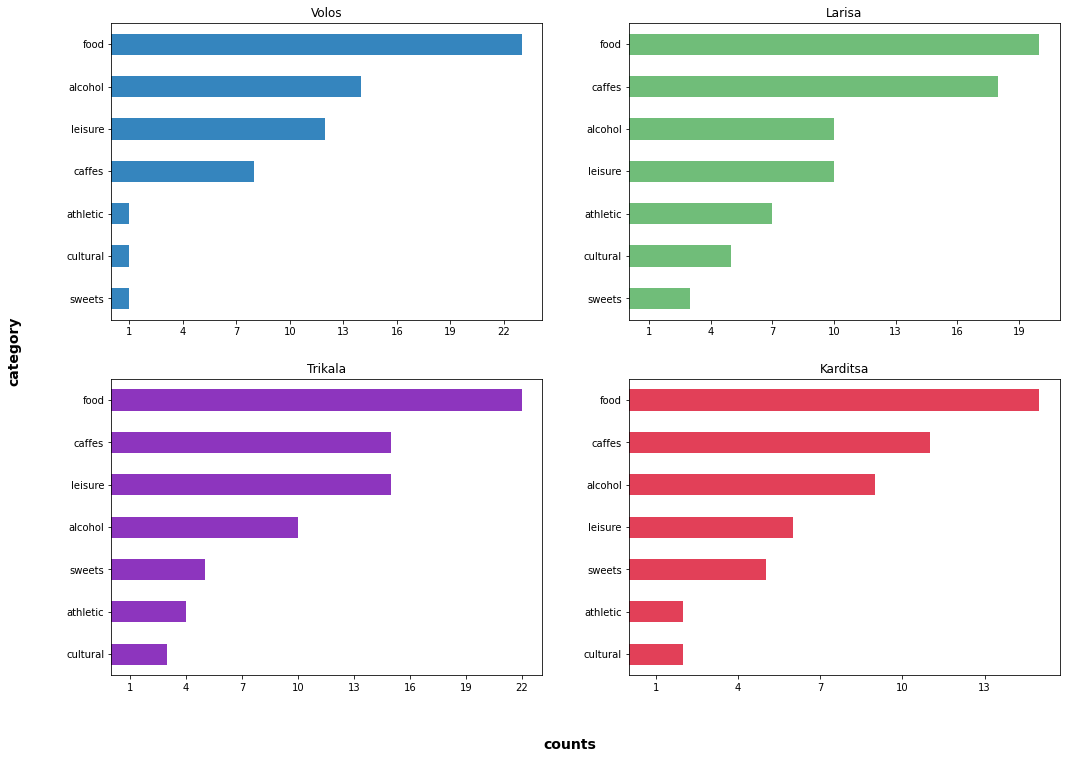

In [39]:
fig = plt.figure(figsize = (21,20)) # create figure

ax_volos = fig.add_subplot(2, 2, 1)
ax_larisa = fig.add_subplot(2, 2, 2)
ax_trikala = fig.add_subplot(2, 2, 3)
ax_karditsa = fig.add_subplot(2,2, 4)

# Subplot Volos
volos_barplot_categories.plot(kind='barh', color='#3585BE', figsize=(17, 12), ax=ax_volos) # add to subplot 1
ax_volos.set_title('Volos')
ax_volos.set_xticks(range(*{'start':1,'stop':cities_categories['volos'].max()+1,'step':3}.values()))
ax_volos.get_legend().remove()

# Subplot Larisa
larisa_barplot_categories.plot(kind='barh', color='#70BD79', figsize=(17, 12), ax=ax_larisa) # add to subplot 1
ax_larisa.set_title('Larisa')
ax_larisa.set_xticks(range(*{'start':1,'stop':cities_categories['larisa'].max()+1,'step':3}.values()))
ax_larisa.get_legend().remove()

# Subplot Trikala
trikala_barplot_categories.plot(kind='barh', color='#8D35BE', figsize=(17, 12), ax=ax_trikala) # add to subplot 1
ax_trikala.set_title('Trikala')
ax_trikala.set_xticks(range(*{'start':1,'stop':cities_categories['trikala'].max()+1,'step':3}.values()))
ax_trikala.get_legend().remove()

# Subplot Karditsa
karditsa_barplot_categories.plot(kind='barh', color='#E24058', figsize=(17, 12), ax=ax_karditsa) # add to subplot 1
ax_karditsa.set_title('Karditsa')
ax_karditsa.set_xticks(range(*{'start':1,'stop':cities_categories['karditsa'].max()+1,'step':3}.values()))
ax_karditsa.get_legend().remove()

fig.text(0.5, 0.04,'counts', fontsize=14, fontweight='bold',ha='center')
fig.text(0.04, 0.5, 'category', fontsize=14, fontweight='bold',va='center', rotation='vertical')


plt.show()

#### create a new dataframe with the mean rating of each venue category for every city

In [40]:
means_df = pd.DataFrame(columns = ["volos score","larisa score","trikala score","karditsa score"])

for category in venue_types:
    volos_mean_rate = round(volos_venues.loc[volos_venues['type'].eq(category)].mean()['rating'],2)
    larisa_mean_rate = round(larisa_venues.loc[larisa_venues['type'].eq(category)].mean()['rating'],2)
    trikala_mean_rate = round(trikala_venues.loc[trikala_venues['type'].eq(category)].mean()['rating'],2)
    karditsa_mean_rate = round(karditsa_venues.loc[karditsa_venues['type'].eq(category)].mean()['rating'],2)

    new_row = [volos_mean_rate, larisa_mean_rate, trikala_mean_rate, karditsa_mean_rate]

    means_df.loc[category] = new_row
means_df.reindex(index=venue_types, columns=sorted(cities_categories.columns))  
means_df

,volos score,larisa score,trikala score,karditsa score
food,8.42,7.82,7.67,7.48
caffes,8.36,7.88,7.58,7.81
alcohol,8.30,8.27,7.72,7.49
leisure,7.87,7.89,7.88,7.90
athletic,7.40,7.76,7.75,8.40
cultural,6.90,7.56,8.17,8.05
sweets,8.40,8.33,7.90,7.38


#### merge the 2 dataframe above to have 1 overview dataframe of the category venues for the 4 cities

In [41]:
metrics_df = cities_categories.merge(means_df, left_index=True, right_index=True)
metrics_df = metrics_df.reindex(index=venue_types, columns=sorted(metrics_df.columns))

metrics_df

,karditsa,karditsa score,larisa,larisa score,trikala,trikala score,volos,volos score
food,15,7.48,20,7.82,22,7.67,23,8.42
caffes,11,7.81,18,7.88,15,7.58,8,8.36
alcohol,9,7.49,10,8.27,10,7.72,14,8.30
leisure,6,7.90,10,7.89,15,7.88,12,7.87
athletic,2,8.40,7,7.76,4,7.75,1,7.40
cultural,2,8.05,5,7.56,3,8.17,1,6.90
sweets,5,7.38,3,8.33,5,7.90,1,8.40


#### For every city, we will find the highest reated venue for every venue type and create a dataframe with the top venues of each City.
#### We will substract these venues from the original dataframes of the cities
#### Merge the top venues dataframe to to the metrics dataframe

for Volos

In [42]:
# take the top venues
volos_best = volos_venues.loc[volos_venues.groupby('type')['rating'].agg('idxmax')]

# subtracking them from the original dataframe of the city
volos_venues = pd.concat([volos_venues, volos_best]).drop_duplicates(keep=False)

# append a new column ['volos best']  to the metrics_df dataframe
metrics_df = metrics_df.merge(volos_best.set_index('type')['rating'], left_index=True, right_index=True).rename(columns={'rating' : 'volos best'})

for Larisa

In [43]:
larisa_best = larisa_venues.loc[larisa_venues.groupby('type')['rating'].agg('idxmax')]
larisa_venues = pd.concat([larisa_venues, larisa_best]).drop_duplicates(keep=False)
metrics_df = metrics_df.merge(larisa_best.set_index('type')['rating'], left_index=True, right_index=True).rename(columns={'rating' : 'larisa best'})

for Trikala

In [44]:
trikala_best = trikala_venues.loc[trikala_venues.groupby('type')['rating'].agg('idxmax')]
trikala_venues = pd.concat([trikala_venues, trikala_best]).drop_duplicates(keep=False)
metrics_df = metrics_df.merge(trikala_best.set_index('type')['rating'], left_index=True, right_index=True).rename(columns={'rating' : 'trikala best'})

for Karditsa

In [45]:
karditsa_best = karditsa_venues.loc[karditsa_venues.groupby('type')['rating'].agg('idxmax')]
karditsa_venues = pd.concat([karditsa_venues, karditsa_best]).drop_duplicates(keep=False)
metrics_df = metrics_df.merge(karditsa_best.set_index('type')['rating'], left_index=True, right_index=True).rename(columns={'rating' : 'karditsa best'})

In [46]:
metrics_df = metrics_df.reindex(sorted(metrics_df.columns), axis=1)

## 5. First observations 

In [47]:
metrics_df

,karditsa,karditsa best,karditsa score,larisa,larisa best,larisa score,trikala,trikala best,trikala score,volos,volos best,volos score
food,15,8.1,7.48,20,8.8,7.82,22,8.3,7.67,23,9.2,8.42
caffes,11,8.8,7.81,18,8.9,7.88,15,8.3,7.58,8,9.0,8.36
alcohol,9,8.3,7.49,10,8.8,8.27,10,8.4,7.72,14,8.7,8.30
leisure,6,9.0,7.90,10,8.8,7.89,15,8.8,7.88,12,9.5,7.87
athletic,2,8.4,8.40,7,8.6,7.76,4,8.5,7.75,1,7.4,7.40
cultural,2,8.2,8.05,5,9.2,7.56,3,8.9,8.17,1,6.9,6.90
sweets,5,7.8,7.38,3,8.9,8.33,5,8.0,7.90,1,8.4,8.40


- The most frequent venue categories are explained by the nature of Greece's economy which relies a lot on Tourism, local or foreign

- The highest mean score is found in Volos, for the category of food (8.42). That is explained by the fact that region is weel known for it's restaurants with tsipouro (a drink with alcohol). In addtion the most venues in a categeory are again found in the food category of Volos (23), despite the fact that it is second to population, after Larisa.

- The highest ratings are for the city of Larisa, the biggest in population <br>
With Volos, the 2nd to population, coming next, but with a low rating in cultural, although it is a city with archeological cites and museums, since these are venues that were not rated by the users of Foursquare.

## 6. Visualization : Let's see everything on the map

Since we did not find any trends for the cities of Thessaly, we will only visualize the regular venues on the map with green circles, and the cities with blue markers

#### function to create a map displaying 4square venues

In [48]:
'''
input city is the tuple of the city we want to create a map (latitude, longitude, name), the city's venues,
a starting zoom for the map, a marker size for displayed the venues with markers, and a radius to create a red circle
around the city (the last 3 are set by default if not given explicitely)

output is a Folium map with a red circle around the city and markers displaying the venues
'''

def visualize(city, city_venues, zoom_start=12, marker_radious = 4, area_radius = 3000) :
    city_coordinates =(city[0],city[1])
    city_name = city[2]
    map_diplayed = folium.Map(location=city_coordinates, zoom_start=zoom_start)
    
    folium.Circle(
        location=city_coordinates,
        radius=area_radius,
        color='red',
        fill=False,    
    ).add_to(map_diplayed)
    
    food_df = city_venues.loc[city_venues['type'].eq("food")]
    leisure_df = city_venues.loc[city_venues['type'].eq("leisure")]
    alcohol_df = city_venues.loc[city_venues['type'].eq("alcohol")]
    athletic_df = city_venues.loc[city_venues['type'].eq("athletic")]
    caffeterias_df = city_venues.loc[city_venues['type'].eq("caffes")]
    sweets_df = city_venues.loc[city_venues['type'].eq("sweets")]
    cultural_df = city_venues.loc[city_venues['type'].eq("cultural")]
    
    dfs_list = [food_df,leisure_df,alcohol_df,athletic_df,caffeterias_df,sweets_df,cultural_df]
    colors = ['red','green','blue','yellow','indigo','violet ','orange']
    fills = ['#cc3131','#58cc31','#3931cc','#ecf00e','#a897a8','#58cc31','#fc9c00']
    
    for i in range(len(dfs_list)) :
        for lat, lng, category, rate, nam in zip(dfs_list[i]['latitude'], dfs_list[i]['longitude'], dfs_list[i]['categories'], dfs_list[i]['rating'], dfs_list[i]['name']):
            label = folium.Popup((nam + ", " + category + " : " + str(rate)), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=marker_radious,
                popup=label,
                color=colors[i],
                fill=True,
                fill_color=fills[i],
                fill_opacity=0.7,
                prefer_canvas=True,
            parse_html=False).add_to(map_diplayed)
            
    return map_diplayed

### we create the maps

and draw a red circle in radious of 3 km, for Volos at 6 km

the left map will be all the venues, while on the right map will be the top venues per type 

In [49]:
# all venues except the top of each category
volos_map = visualize(volos, volos_venues, area_radius = 6000)
larisa_map = visualize(larisa, larisa_venues)
trikala_map = visualize(trikala, trikala_venues)
karditsa_map = visualize(karditsa, karditsa_venues)

# top venues per category
volos_top = visualize(volos, volos_best, marker_radious = 7, area_radius = 6000)
larisa_top = visualize(larisa, larisa_best, marker_radious = 7)
trikala_top = visualize(trikala, trikala_best, marker_radious = 7)
karditsa_top = visualize(karditsa, karditsa_best, marker_radious = 7)

In [50]:
from IPython.core.display import display, HTML

In [51]:
'''
function to display 2 Folium maps side by side in 1 cell

input are the 2 maps we want to display
'''

def two_maps(map_all, map_top):
    return HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_all.get_root().render().replace('"', '&quot;'),500,500,
                   map_top.get_root().render().replace('"', '&quot;'),500,500))

### See the maps

 We can see every venue’s name, category and rating by clicking on it on the map

### Volos

In [102]:
volos_v = two_maps(volos_map,volos_top)

display(volos_v)

$\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:red">food</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:green">leisure</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:blue">alcohol</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:yellow">athletic</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:indigo">caffeteria</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:violet">sweets</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:orange">cultural</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

In [53]:
metrics_df[['volos','volos score','volos best']]

,volos,volos score,volos best
food,23,8.42,9.2
caffes,8,8.36,9.0
alcohol,14,8.30,8.7
leisure,12,7.87,9.5
athletic,1,7.40,7.4
cultural,1,6.90,6.9
sweets,1,8.40,8.4


- Most of the venues are alongside the sea, and mostly venues for eating are in the central city

- The highest ratings for the venue types of food, cafes, and athletics are inside the radius of 3-6 km, meaning we correctly took a bigger radius for exploring in the case of Volos

<br>

### Larisa

In [103]:
larisa_v = two_maps(larisa_map,larisa_top)

display(larisa_v)

$\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:red">food</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:green">leisure</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:blue">alcohol</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:yellow">athletic</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:indigo">caffeteria</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:violet">sweets</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:orange">cultural</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

In [55]:
metrics_df[['larisa','larisa score','larisa best']]

,larisa,larisa score,larisa best
food,20,7.82,8.8
caffes,18,7.88,8.9
alcohol,10,8.27,8.8
leisure,10,7.89,8.8
athletic,7,7.76,8.6
cultural,5,7.56,9.2
sweets,3,8.33,8.9


- Most of the venues are in the city's center and alongside a main road connecting the city with the national highway

- The top rating is found for a historic site of the city, the Ancient Theatre of Larissa

<br>

### Trikala

In [104]:
trikala_v = two_maps(trikala_map,trikala_top)

display(trikala_v)

$\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:red">food</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:green">leisure</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:blue">alcohol</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:yellow">athletic</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:indigo">caffeteria</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:violet">sweets</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:orange">cultural</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

In [57]:
metrics_df[['trikala','trikala score','trikala best']]

,trikala,trikala score,trikala best
food,22,7.67,8.3
caffes,15,7.58,8.3
alcohol,10,7.72,8.4
leisure,15,7.88,8.8
athletic,4,7.75,8.5
cultural,3,8.17,8.9
sweets,5,7.90,8.0


- Most of the venues are in the city's center and alongside the city's biggest roads leading to it

- Most of the top rated venues are found in a small distance of the city's center

<br>

### Karditsa

In [105]:
karditsa_v = two_maps(karditsa_map,karditsa_top)

display(karditsa_v)

$\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:red">food</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:green">leisure</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:blue">alcohol</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:yellow">athletic</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:indigo">caffeteria</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:violet">sweets</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
<span style="color:orange">cultural</span> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

In [59]:
metrics_df[['karditsa','karditsa score','karditsa best']]

,karditsa,karditsa score,karditsa best
food,15,7.48,8.1
caffes,11,7.81,8.8
alcohol,9,7.49,8.3
leisure,6,7.90,9.0
athletic,2,8.40,8.4
cultural,2,8.05,8.2
sweets,5,7.38,7.8


- There is high ratings for the venues of leisure type , with 6 venues in it. The top rated are a Park and a Plaza

- Although for the economy of municipality of Karditsa farming and livestocking has a great role, in the venue type of fodd we find the lowest count and ratings among the 4 cities

## 7 Clustering based on the ratings of the venues

We will use the Unsupervised Machine Learning technique of clustering to discover natural grouping for the venues of every city. <br>
The variables we will take into account will be the ['type'] and '[rating]' of the venues

In [60]:
from sklearn.cluster import KMeans

function to plot clusterized venues

In [61]:
'''
input city is the tuple of the city we search trends for (latitude, longitude, name)
and a dataframe with columns ['latitude','longitude','type', 'rating','cluster','categories']
returns a map displaying the venues on a map and the different clusters they belong and some info for each
'''

def visualize_clusters(city, clustered_venues, zoom_start=14, marker_radious = 4, area_radius = 3000) :
    city_coordinates =(city[0],city[1])
    city_name = city[2]
    map_diplayed = folium.Map(location=city_coordinates, zoom_start=zoom_start)
    
    # append the following lists to try number of clusters>6
    colors = ['red','green','blue','yellow','#8075E6','#aa945B','#a897a8']
    fills = ['#cc3131','#58cc31','#3931cc','#ecf00e','#a897a8,','#aa945B','#a897a8']
    
    for lat, lng, venue_type, rate, clust, cat in zip(clustered_venues['latitude'], clustered_venues['longitude'], clustered_venues['type'], clustered_venues['rating'],clustered_venues['cluster'],  clustered_venues['categories']):
        label = folium.Popup((venue_type + " , " +cat + " : " + str(rate)), parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=marker_radious,
            popup=label,
            color=colors[clust],
            fill=True,
            fill_color=fills[clust],
            fill_opacity=0.7,
            prefer_canvas=True,
        parse_html=False).add_to(map_diplayed)
            
    return map_diplayed

create an empty dataframe to keep all the clustered venues

In [62]:
column_names = ['categories','type','rating','latitude','longitude','cluster','city']
clustered_all = pd.DataFrame(columns = column_names)

### clustering procedure

we want all the venues to be clustered, so we append the highest rated venues per type dataframe we created earlier (volos_best,larisa_best,karditsa_best,trikala_best) to the original venues per city dataframes

In [63]:
volos_venues = volos_venues.append(volos_best)
larisa_venues = larisa_venues.append(larisa_best)
karditsa_venues = karditsa_venues.append(karditsa_best)
trikala_venues = trikala_venues.append(trikala_best)

volos_venues.reset_index(drop=True, inplace=True)
larisa_venues.reset_index(drop=True, inplace=True)
karditsa_venues.reset_index(drop=True, inplace=True)
trikala_venues.reset_index(drop=True, inplace=True)

#### function to automate the clustering procedure

we did not normalize the data because it led to overfit to the variable ['type']

In [64]:
'''
takes as input the clustering algorithm, the venues to be clustered, and the name of the city
'''
def cluster_venues (cluster_algo, city_venues, city_name) :
    X = city_venues[['type', 'rating']]
    # X_onehot_encoding
    X_onehot_encoding = pd.get_dummies(X[['type']], prefix="type", prefix_sep="-")
    X = X.merge(X_onehot_encoding, left_index=True, right_index=True)
    # drop original columnn ['type']
    X.drop(['type'], axis=1, inplace=True)
    X['rating'] = X['rating'].replace(np.nan, X['rating'].mean())
    k_means.fit(X)
    clusterised = k_means.labels_
    city_venues['cluster'] = clusterised

    clustered_city = city_venues[['categories','type','rating','latitude','longitude','cluster']]
    clustered_city['city'] = city_name
    
    return clustered_city

A criterion to decide how many will be the clusters we will use is the <strong> inertia </strong> (sum of squared error between each point and its cluster center)

Text(0, 0.5, 'Inertia')

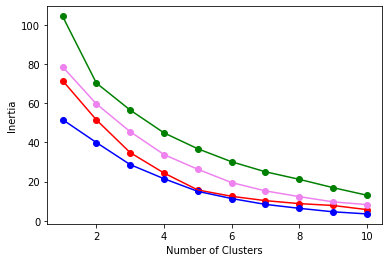

In [65]:
volos_inertia = []
larisa_inertia = []
karditsa_inertia = []
trikala_inertia = []

list_num_clusters = list(range(1,11))
for clusters_number in list_num_clusters:
    # initiate kmeans algorithmk with clusters 1-10
    k_means = KMeans(init = "k-means++", n_clusters = clusters_number, n_init = 12)
    
    # volos
    volos_clustered = cluster_venues(k_means , volos_venues, "volos")
    volos_inertia.append(k_means.inertia_)
    
    # larisa
    larisa_clustered = cluster_venues(k_means , larisa_venues, "larisa")
    larisa_inertia.append(k_means.inertia_)
    
    # karditsa
    karditsa_clustered = cluster_venues(k_means , karditsa_venues, "karditsa")
    karditsa_inertia.append(k_means.inertia_)
    
    # trikala
    trikala_clustered = cluster_venues(k_means , trikala_venues, "trikala")
    trikala_inertia.append(k_means.inertia_)
    
plt.plot(list_num_clusters,volos_inertia, color="red")
plt.scatter(list_num_clusters,volos_inertia, color="red")

plt.plot(list_num_clusters,larisa_inertia, color="green")
plt.scatter(list_num_clusters,larisa_inertia, color="green")

plt.plot(list_num_clusters,karditsa_inertia, color="blue")
plt.scatter(list_num_clusters,karditsa_inertia, color="blue")

plt.plot(list_num_clusters,trikala_inertia, color="violet")
plt.scatter(list_num_clusters,trikala_inertia, color="violet")

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

The elbow in the plot above is not clear for every city <br>
The number of clusters we decided was 3, because it led to the optimal and more distinct and interpretative clusters. <br>
For easy of repeatable analysis, if we want to test for another number of clusters, we change the cell below and expand the 2 lists for colors at def visualize_clusters (cell 58)

In [66]:
clusters_number = 3

k_means = KMeans(init = "k-means++", n_clusters = clusters_number, n_init = 12)

#### Volos

In [67]:
volos_clustered = cluster_venues(k_means , volos_venues, "volos")

clustered_all = clustered_all.append(volos_clustered)

create the appropriate map for Volos

In [68]:
vol = visualize_clusters(volos, volos_clustered, zoom_start=12)

#### Larisa

In [69]:
larisa_clustered = cluster_venues(k_means , larisa_venues, "larisa")

clustered_all = clustered_all.append(larisa_clustered)

create the appropriate map for Larisa

In [70]:
lar = visualize_clusters(larisa, larisa_clustered)

#### Trikala

In [71]:
trikala_clustered = cluster_venues(k_means , trikala_venues, "trikala")

clustered_all = clustered_all.append(trikala_clustered)

create the appropriate map for Trikala

In [72]:
tri = visualize_clusters(trikala, trikala_clustered)

#### Karditsa

In [73]:
karditsa_clustered = cluster_venues(k_means , karditsa_venues, "karditsa")

clustered_all = clustered_all.append(karditsa_clustered)

create the appropriate map for Karditsa

In [74]:
kar = visualize_clusters(karditsa, karditsa_clustered)

drop columns ['latitude', 'longitude'] from the clustered venus dataframe, since we needed them only for the production of maps for each city

In [75]:
clustered_all.drop(['latitude', 'longitude','categories'], axis=1, inplace=True)

### exampine every city in regard to it's clusters

In [76]:
from itertools import chain,cycle
from IPython.display import display_html

#### function to display 2 dataframes in 1 cell

In [77]:
'''
function to display more than 1 dataframes side by side in 1 cell

input are the dataframes we want to display and their titles

for better visualization in this project this function is used with 3 input dataframes and the second is empty
'''

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str += '<th style="text-align:center"><td style="vertical-align:top">'
        html_str += f'<h2>{title}</h2>'
        html_str += df.to_html().replace('table','table style="display:inline"')
        html_str +=' </td></th>'
    display_html(html_str,raw=True)

create a dataframe <i>(total)</i> containing the mean rating and count of venues, per city per cluster 

In [78]:
copied = clustered_all.copy()

In [79]:
rates = (copied.groupby(["city","cluster"])["rating"].mean()).to_frame()

In [80]:
counts = (copied.groupby(["city","cluster"])["rating"].count()).to_frame()

In [81]:
total = counts.merge(rates, left_index=True, right_index=True)
total.rename(columns={'rating_x' : 'count' , 'rating_y' : 'mean rating'}, inplace = True)

create a dataframe <i>(types)</i> to see how many venues per type has each cluster

In [82]:
types = (copied.groupby(["city","cluster","type"])["type"].count()).to_frame()
types.rename(columns={'type' : 'count'}, inplace = True)

see the venues info per city per cluster

In [83]:
display_side_by_side(total,pd.DataFrame(),types, titles=['ratings','','venues per category'])

ratings 
 
 
 
 
 count 
 mean rating 
 
 
 city 
 cluster 
 
 
 
 
 
 
 karditsa 
 0 
 14 
 7.478571 
 
 
 1 
 23 
 7.660870 
 
 
 2 
 11 
 7.809091 
 
 
 larisa 
 0 
 15 
 6.613333 
 
 
 1 
 13 
 8.076923 
 
 
 2 
 39 
 8.348718 
 
 
 trikala 
 0 
 33 
 7.842424 
 
 
 1 
 13 
 7.576923 
 
 
 2 
 18 
 7.672222 
 
 
 volos 
 0 
 21 
 8.476190 
 
 
 1 
 8 
 6.837500 
 
 
 2 
 27 
 8.470370 
 
 
 
 
 
 
 
 
 
 
 venues per category 
 
 
 
 
 
 count 
 
 
 city 
 cluster 
 type 
 
 
 
 
 
 karditsa 
 0 
 food 
 15 
 
 
 1 
 alcohol 
 9 
 
 
 athletic 
 2 
 
 
 cultural 
 2 
 
 
 leisure 
 6 
 
 
 sweets 
 5 
 
 
 2 
 caffes 
 11 
 
 
 larisa 
 0 
 athletic 
 1 
 
 
 caffes 
 5 
 
 
 cultural 
 3 
 
 
 food 
 3 
 
 
 leisure 
 3 
 
 
 1 
 food 
 17 
 
 
 2 
 alcohol 
 10 
 
 
 athletic 
 6 
 
 
 caffes 
 13 
 
 
 cultural 
 2 
 
 
 leisure 
 7 
 
 
 sweets 
 3 
 
 
 trikala 
 0 
 alcohol 
 10 
 
 
 athletic 
 4 
 
 
 cultural 
 3 
 
 
 leisure 
 15 
 
 
 sweets 
 5 
 
 
 1 
 caffes 
 15 
 
 
 2 
 food 
 22 
 
 
 volos 
 0 
 food 
 22 
 
 
 1 
 alcohol 
 1 
 
 
 athletic 
 1 
 
 
 cultural 
 1 
 
 
 food 
 1 
 
 
 leisure 
 4 
 
 
 2 
 alcohol 
 13 
 
 
 caffes 
 8 
 
 
 leisure 
 8 
 
 
 sweets 
 1

There are to totally 22 unrated venues for the 4 cities in total of 243
That is the reason sometimes we see some small differences in the total counts per city/per cluster in the dataframes below, since in the ratings count dataframe (left) the [count] column takes under account only the venues with nymperic rating.
The venues without rating will be displayed as we examine every city.

The type of unrated venues per city per cluster, are shown below

In [84]:
clustered_all[clustered_all['rating'].isna()].sort_values('cluster').groupby(["city","cluster"])["type"].unique().to_frame()

type
city     cluster                    
karditsa 0                    [food]
         1                [athletic]
larisa   1                    [food]
         2         [caffes, leisure]
trikala  0         [leisure, sweets]
         1                  [caffes]
         2                    [food]
volos    0                    [food]
         2        [leisure, alcohol]

## Let's see everything on maps

We can see every venue's type, category and rating by clicking on it on the map

### Larisa

In [85]:
lar

not rated venues

In [86]:
larisa_venues[larisa_venues['rating'].isna()].sort_values('cluster').reset_index(drop = True)

,name,categories,type,rating,latitude,longitude,id,cluster
0,Νέα Καστελλα,Greek Restaurant,food,NaN,39.627662,22.432223,4e328447ae60f21828d4c6cf,1
1,Γαλαξίας,Supermarket,food,NaN,39.633894,22.438311,50e81849e4b06746fb33c7f6,1
2,Κικιρίκου,Fried Chicken Joint,food,NaN,39.653231,22.434889,4f707a88e4b07a4bc71bcc70,1
3,Goody's,Fast Food Restaurant,food,NaN,39.658974,22.404417,4ce6e0bb8ef78cfac8658f9b,1
4,Άλσος Λάρισας,Park,leisure,NaN,39.655171,22.413340,4e751314b993a71aa3a36e3d,2
5,Corner Cafe,Café,caffes,NaN,39.631186,22.449050,4cc488bdd43ba14364bf67f8,2


metrics

In [87]:
display_side_by_side(total.loc["larisa"],pd.DataFrame(),types.loc["larisa"], pd.DataFrame(), metrics_df[['larisa','larisa best','larisa score']], titles=['Total ratings','','venues per category','', "metrics"])

Total ratings 
 
 
 
 count 
 mean rating 
 
 
 cluster 
 
 
 
 
 
 
 0 
 15 
 6.613333 
 
 
 1 
 13 
 8.076923 
 
 
 2 
 39 
 8.348718 
 
 
 
 
 
 
 
 
 
 
 venues per category 
 
 
 
 
 count 
 
 
 cluster 
 type 
 
 
 
 
 
 0 
 athletic 
 1 
 
 
 caffes 
 5 
 
 
 cultural 
 3 
 
 
 food 
 3 
 
 
 leisure 
 3 
 
 
 1 
 food 
 17 
 
 
 2 
 alcohol 
 10 
 
 
 athletic 
 6 
 
 
 caffes 
 13 
 
 
 cultural 
 2 
 
 
 leisure 
 7 
 
 
 sweets 
 3 
 
 
 
 
 
 
 
 
 
 
 metrics 
 
 
 
 larisa 
 larisa best 
 larisa score 
 
 
 
 
 food 
 20 
 8.8 
 7.82 
 
 
 caffes 
 18 
 8.9 
 7.88 
 
 
 alcohol 
 10 
 8.8 
 8.27 
 
 
 leisure 
 10 
 8.8 
 7.89 
 
 
 athletic 
 7 
 8.6 
 7.76 
 
 
 cultural 
 5 
 9.2 
 7.56 
 
 
 sweets 
 3 
 8.9 
 8.33

- Food venues create a distinct cluster, this is found in all 4 cities

- We see generally high ratings for most of the venues

- The greatest are spread in the center of the city and are most caffees and food

- The lowest rated cluster is for the furthest of the city's center venues, found mostly in the main road connecting the city with the national highway

- The cultural venues of Larisa have high ratings (with the exception of a music center)

In [88]:
larisa_venues[larisa_venues['type'] == 'cultural'].sort_values('rating',ascending=False).reset_index(drop = True)

,name,categories,type,rating,latitude,longitude,id,cluster
0,Ancient Theatre of Larissa (Αρχαίο Θέατρο Λάρι...,Historic Site,cultural,9.2,39.640008,22.414713,4c40a11fda3dc928fea3c7b9,2
1,Φρούριο,Historic Site,cultural,8.3,39.641620,22.414491,4f3022b2121d3f490074b848,2
2,"Studio 3 (Palace 91,4)",Music Venue,cultural,7.4,39.642809,22.429286,4dc58cb6fa76d685cde3c214,0
3,ΑΒ Βασιλόπουλος,Shopping Mall,cultural,7.4,39.636255,22.436260,57ebe0c0498efbe718341c5f,0
4,Starz Live,Music Venue,cultural,5.5,39.657651,22.439292,4ee3d6f193adf8e1a714474d,0


<br>

###  Volos

In [89]:
vol

not rated venues

In [90]:
volos_venues[volos_venues['rating'].isna()].sort_values('cluster').reset_index(drop = True)

,name,categories,type,rating,latitude,longitude,id,cluster
0,To kalamaki,Restaurant,food,NaN,39.325409,22.926775,575425d2498e02e2045e71ca,0
1,Πλατεία Διμηνίου,Plaza,leisure,NaN,39.359314,22.896027,5611143c498eb70a6ebe058b,2
2,Hotel Filoxenia,Hotel,leisure,NaN,39.326206,22.926289,4debe8231520ed580a544a4e,2
3,Ammos Seaside Lounge,Beach Bar,alcohol,NaN,39.324950,22.926922,5b3fb8b97cd14c004461510f,2


metrics

In [91]:
display_side_by_side(total.loc["volos"],pd.DataFrame(),types.loc["volos"], pd.DataFrame(), metrics_df[['volos','volos best','volos score']], titles=['Total ratings','','venues per category','', "metrics"])

Total ratings 
 
 
 
 count 
 mean rating 
 
 
 cluster 
 
 
 
 
 
 
 0 
 21 
 8.47619 
 
 
 1 
 8 
 6.83750 
 
 
 2 
 27 
 8.47037 
 
 
 
 
 
 
 
 
 
 
 venues per category 
 
 
 
 
 count 
 
 
 cluster 
 type 
 
 
 
 
 
 0 
 food 
 22 
 
 
 1 
 alcohol 
 1 
 
 
 athletic 
 1 
 
 
 cultural 
 1 
 
 
 food 
 1 
 
 
 leisure 
 4 
 
 
 2 
 alcohol 
 13 
 
 
 caffes 
 8 
 
 
 leisure 
 8 
 
 
 sweets 
 1 
 
 
 
 
 
 
 
 
 
 
 metrics 
 
 
 
 volos 
 volos best 
 volos score 
 
 
 
 
 food 
 23 
 9.2 
 8.42 
 
 
 caffes 
 8 
 9.0 
 8.36 
 
 
 alcohol 
 14 
 8.7 
 8.30 
 
 
 leisure 
 12 
 9.5 
 7.87 
 
 
 athletic 
 1 
 7.4 
 7.40 
 
 
 cultural 
 1 
 6.9 
 6.90 
 
 
 sweets 
 1 
 8.4 
 8.40

- Food venues create a distincy cluster, this is found in all 4 cities

- The highest rating are inside the city and in mount Pilion

- The lowest rating are the furthest from the city, but still alongside the sea

- In the leisure type we see higher ratings for what was done from the local government in comparison to what is private economic activity

In [92]:
volos_venues[volos_venues['type'] == 'leisure'].sort_values('rating',ascending=False).reset_index(drop = True)

,name,categories,type,rating,latitude,longitude,id,cluster
0,Παραλία Βόλου,Pedestrian Plaza,leisure,9.5,39.358068,22.948776,4de126ff18380dc4dd41b00d,2
1,Agios Konstantinos Park (Πάρκο Αγίου Κωνσταντί...,Park,leisure,8.9,39.356730,22.953834,4f524211e4b0ac6d0bcef9fd,2
2,Πήλιο,Mountain,leisure,8.7,39.383532,22.997752,514dc843e4b0d91e9293e9ac,2
3,Agios Nikolaos Square (Πλατεία Αγίου Νικολάου),Plaza,leisure,8.6,39.360179,22.949553,50c3a7fd498ef1fd4464c339,2
4,Domotel Xenia Volos,Hotel,leisure,8.5,39.353272,22.957141,4bd1cd775e0cce724c03a284,2
5,Anavros Beach (Παραλία Αναύρου),Beach,leisure,8.0,39.350509,22.962294,4e3696c2fa7656ba317c19bd,2
6,Ermou (Ερμού),Pedestrian Plaza,leisure,7.7,39.361292,22.947714,4fa270dee4b0abdff9a7bcca,1
7,Αλυκές,Beach,leisure,6.9,39.324737,22.925909,4e3a88941838961aff006ded,1
8,Kalloni beach resort & Spa,Resort,leisure,6.1,39.328984,22.926185,5039e5dfe4b0e79b212e7303,1
9,Amaze Club,Nightclub,leisure,5.8,39.338620,22.938719,4dbb583793a08f9274a2b3c3,1


<br>

### Trikala

In [93]:
tri

not rated venues

In [94]:
trikala_venues[trikala_venues['rating'].isna()].sort_values('cluster')

,name,categories,type,rating,latitude,longitude,id,cluster
59,Πλατεία ΟΣΕ(ΚΔΑΠ),Park,leisure,NaN,39.547250,21.764129,5022db5be4b0e6fe19fce8f4,0
60,Πλατεία Φιλοσόφων,Park,leisure,NaN,39.546135,21.767827,4ed7ee60f5b915cfe2d92b3a,0
61,Μέλισσα,Dessert Shop,sweets,NaN,39.545355,21.768281,4fb89a22e4b093431c459bdc,0
62,Παγοδρόμιο Μύλου Ξωτικών,Playground,leisure,NaN,39.545635,21.758890,50b91a07e4b0e9ecea75d585,0
63,Granello,Cafeteria,caffes,NaN,39.564529,21.752278,57e1031c498e16b14c8c057d,1
64,Τσιμπλής Cafe,Café,caffes,NaN,39.542275,21.758482,4f4d27ffe5e882092459e119,1
57,"Billy's ""Πλατεία Βουβής""",BBQ Joint,food,NaN,39.555512,21.761352,4e2a8c56091ac5a470e5433e,2
58,Το χωριάτικο ψωμί,Bakery,food,NaN,39.557221,21.758896,51a08de6498e3fa33f233022,2
65,Κουίντα,Ouzeri,food,NaN,39.570562,21.757149,52a3400911d2996c3dc683d1,2
66,Παλιό Μεράκι,Restaurant,food,NaN,39.535752,21.752805,4e0db53de4cd27fc7d27b5f1,2


metrics

In [95]:
display_side_by_side(total.loc["trikala"],pd.DataFrame(),types.loc["trikala"],pd.DataFrame(), metrics_df[['trikala','trikala best','trikala score']], titles=['Total ratings','','venues per category','', "metrics"])

Total ratings 
 
 
 
 count 
 mean rating 
 
 
 cluster 
 
 
 
 
 
 
 0 
 33 
 7.842424 
 
 
 1 
 13 
 7.576923 
 
 
 2 
 18 
 7.672222 
 
 
 
 
 
 
 
 
 
 
 venues per category 
 
 
 
 
 count 
 
 
 cluster 
 type 
 
 
 
 
 
 0 
 alcohol 
 10 
 
 
 athletic 
 4 
 
 
 cultural 
 3 
 
 
 leisure 
 15 
 
 
 sweets 
 5 
 
 
 1 
 caffes 
 15 
 
 
 2 
 food 
 22 
 
 
 
 
 
 
 
 
 
 
 metrics 
 
 
 
 trikala 
 trikala best 
 trikala score 
 
 
 
 
 food 
 22 
 8.3 
 7.67 
 
 
 caffes 
 15 
 8.3 
 7.58 
 
 
 alcohol 
 10 
 8.4 
 7.72 
 
 
 leisure 
 15 
 8.8 
 7.88 
 
 
 athletic 
 4 
 8.5 
 7.75 
 
 
 cultural 
 3 
 8.9 
 8.17 
 
 
 sweets 
 5 
 8.0 
 7.90

- Food venues create a distincy cluster, this is found in all 4 cities

- Almost half of the venues are unrated (10/22), in contrast with the rest cities that the unrated are at most 4

- The caffes also create a distinct cluster, this is also found in Karditsa

- The highest rating are mostly about food, located in the very center of the city and alongside the main roads that lead to it

<br>

### Karditsa

In [96]:
kar

not rated venues

In [97]:
karditsa_venues[karditsa_venues['rating'].isna()].sort_values('cluster')

,name,categories,type,rating,latitude,longitude,id,cluster
41,Το Μουράγιο,Greek Restaurant,food,NaN,39.359280,21.916027,52b21635498ea5997ec2e281,0
42,Παλέρμο,Basketball Court,athletic,NaN,39.351821,21.917124,4bbc7eb93de8c9b66dff9aad,1


metrics

In [98]:
total.loc["karditsa"]
display_side_by_side(total.loc["karditsa"],pd.DataFrame(),types.loc["karditsa"],pd.DataFrame(), metrics_df[['karditsa','karditsa best','karditsa score']], titles=['Total ratings','','venues per category','', "metrics"])

Total ratings 
 
 
 
 count 
 mean rating 
 
 
 cluster 
 
 
 
 
 
 
 0 
 14 
 7.478571 
 
 
 1 
 23 
 7.660870 
 
 
 2 
 11 
 7.809091 
 
 
 
 
 
 
 
 
 
 
 venues per category 
 
 
 
 
 count 
 
 
 cluster 
 type 
 
 
 
 
 
 0 
 food 
 15 
 
 
 1 
 alcohol 
 9 
 
 
 athletic 
 2 
 
 
 cultural 
 2 
 
 
 leisure 
 6 
 
 
 sweets 
 5 
 
 
 2 
 caffes 
 11 
 
 
 
 
 
 
 
 
 
 
 metrics 
 
 
 
 karditsa 
 karditsa best 
 karditsa score 
 
 
 
 
 food 
 15 
 8.1 
 7.48 
 
 
 caffes 
 11 
 8.8 
 7.81 
 
 
 alcohol 
 9 
 8.3 
 7.49 
 
 
 leisure 
 6 
 9.0 
 7.90 
 
 
 athletic 
 2 
 8.4 
 8.40 
 
 
 cultural 
 2 
 8.2 
 8.05 
 
 
 sweets 
 5 
 7.8 
 7.38

- Food venues create a distincy cluster, this is found in all 4 cities

- The caffes also create a distinct cluster, this is also found in Trikala

- Few venues have high ratings

- In the leisure type we see higher ratings for what was done from the local government in comparison to what is private economic activity

In [99]:
karditsa_venues[karditsa_venues['type'] == 'leisure'].sort_values('rating',ascending=False).reset_index(drop = True)

,name,categories,type,rating,latitude,longitude,id,cluster
0,Αθλητικό Πάρκο,Park,leisure,9.0,39.362470,21.932340,4baeff45f964a5200fe63be3,1
1,Παυσίλυπο,Park,leisure,8.8,39.364462,21.928102,4c93857a6b35a14390aa12dc,1
2,Πλατεία Λάππα,Plaza,leisure,7.8,39.361160,21.924297,4cb33b9c562d224b096e2c88,1
3,Kierion Hotel,Hotel,leisure,7.5,39.365671,21.919682,51522038e4b0c5b84881b0bd,1
4,Πλατεία Δικαστηρίων Καρδίτσας,Plaza,leisure,7.2,39.366100,21.923564,4e4b7d4545dd5144016c90eb,1
5,Cosi Summer,Nightclub,leisure,7.1,39.346628,21.895287,4fb7d089e4b0e5da459aae5d,1
